# Project Overview
The objective of this project was to analyze the electricity consumption per person data, which provides an estimate of power plant production minus losses, using time series analysis. The data was obtained from the World Bank and the International Energy Agency and covers the period from 1971 to 2014.

## Methodology
Python was used for all the analysis steps, including data cleaning, transformation, and modeling. Initially, an Augmented Dickey-Fuller (ADF) test was performed to determine if the time series was stationary. If the time series was non-stationary, transformations and differencing were applied to make it stationary.

# Environement Setup

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from seaborn import distplot
warnings.filterwarnings("ignore")
sns.set()

## Defining Functions

In [2]:
def tsplot(y, ADF=True, lags=None,title=None, figsize=(15, 7), style ='bmh'):
    """ Plot time series, its ACF and PACF, calculate Dickey–Fullertest
    y - timeseries
    lags - how many lags to include in ACF, PACF calculation
    """
    if title == None:
        title = "Time Series Analysis Plots"
    else:
        title = str(title)
        
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        y.plot(ax=ts_ax)
        
    if ADF:
        p_value = adfuller(y)[1]
        ts_ax.set_title(title + '\n Dickey-Fuller: p_value ={0:.5f}'.format(p_value))
    else:
        ts_ax.set_title(title)
        
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

In [3]:
def tsplot_resid(y, lags=None,title=None, figsize=(15, 7), style='bmh'):
    """
    Plot time series, its ACF and PACF, calculate Dickey–Fuller
    test
    y - timeseries
    lags - how many lags to include in ACF, PACF calculation
    """
    if title == None:
        title = "Time Series Analysis Plots"
    else:
        title = str(title)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qqplot_ax = plt.subplot2grid(layout, (2, 0))
        dist_ax = plt.subplot2grid(layout, (2, 1))
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax)
        qqplot(y,fit=True, line="45", ax=qqplot_ax)
        qqplot_ax.set_title("Normalitée")
        distplot(y, ax=dist_ax)
        dist_ax.set_title("Distribution")
        plt.tight_layout()

# Preprocessing

## Importing Data

In [4]:
df = pd.read_csv("/kaggle/input/algeria-electric-consumption-per-capita-1971-2019/Algeria electricity consumption 1971-2019.csv",
                 index_col=0)
df.head()

,Electric power consumption (kWh per capita)
Year,
1971,133
1972,142
1973,158
1974,170
1975,195


## Preprocessing the Data

In [5]:
df.index = pd.to_datetime(df.index, format="%Y")
df.index = df.index + pd.offsets.YearEnd(0)
df.rename(columns={"Electric power consumption (kWh per capita)":"consumption"},inplace=True)
df.head()

,consumption
Year,
1971-12-31,133
1972-12-31,142
1973-12-31,158
1974-12-31,170
1975-12-31,195


## Plotting the Series

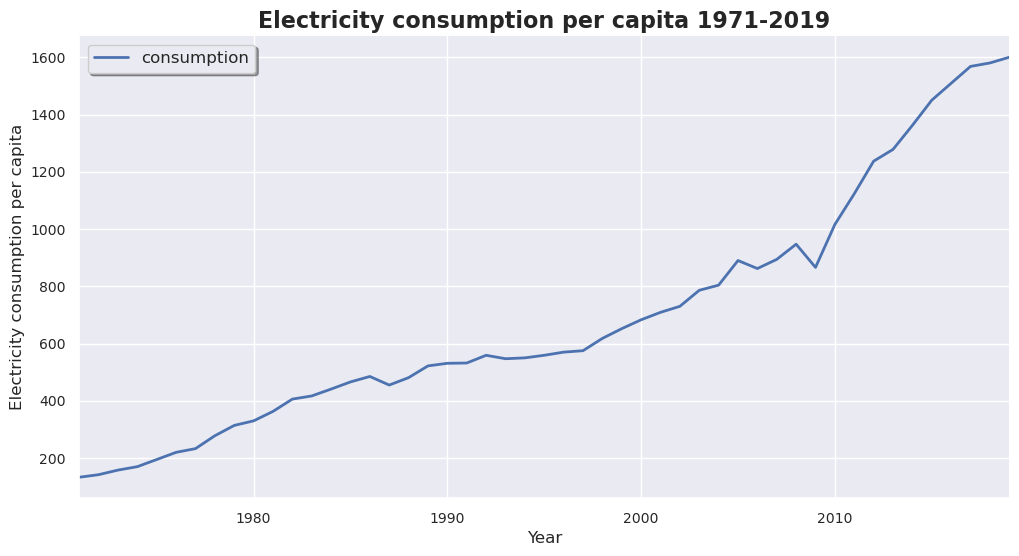

In [6]:
import matplotlib.pyplot as plt

# Set the style to a clean, simple format
#plt.style.use('seaborn-white')

# Create the figure object and axes
fig, ax = plt.subplots(figsize=(12,6))

# Plot the data
df.plot(ax=ax, linewidth=2)

# Set the x and y labels and title
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Electricity consumption per capita", fontsize=12)
ax.set_title("Electricity consumption per capita 1971-2019", fontsize=16, fontweight='bold')

# Add a legend with a shadow effect
ax.legend(loc='upper left', shadow=True, fontsize=12)

# Remove the top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust the tick label font size
ax.tick_params(axis='both', which='major', labelsize=10)

# Display the plot
plt.savefig("electricity_consumption.png")
plt.show()


# Model Selection

## Checking Stationarity

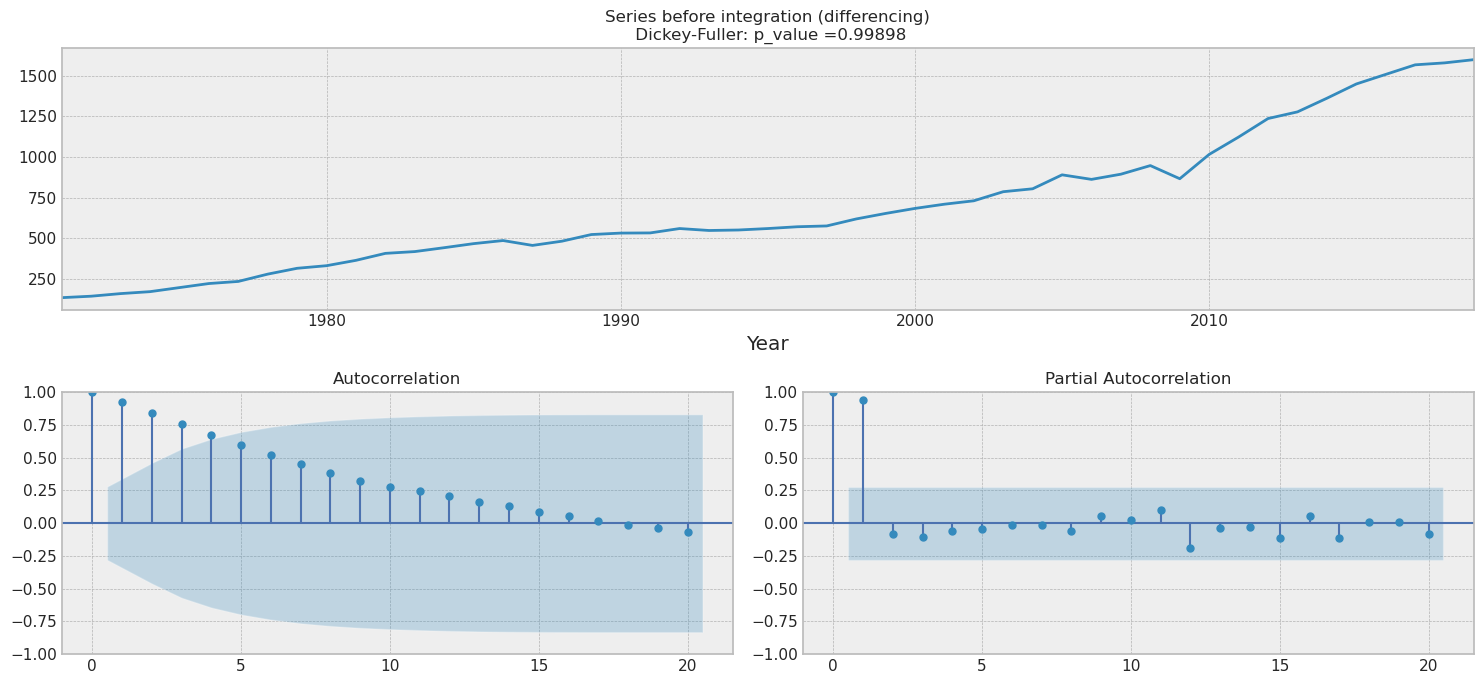

In [7]:
tsplot(df.consumption,lags=20, title= "Series before integration (differencing)")

* A p-value of 0.99898 suggests that there is very strong evidence against rejecting the null hypothesis, and that the time series is likely non-stationary.
* This means that the series may have trends or other patterns that make it difficult to model or analyze. It may be necessary to apply transformations or differencing to make the series stationary before performing further analysis or modeling.

## Differencing

In [8]:
dff = df.diff().dropna()
dff.head()

,consumption
Year,
1972-12-31,9.0
1973-12-31,16.0
1974-12-31,12.0
1975-12-31,25.0
1976-12-31,25.0


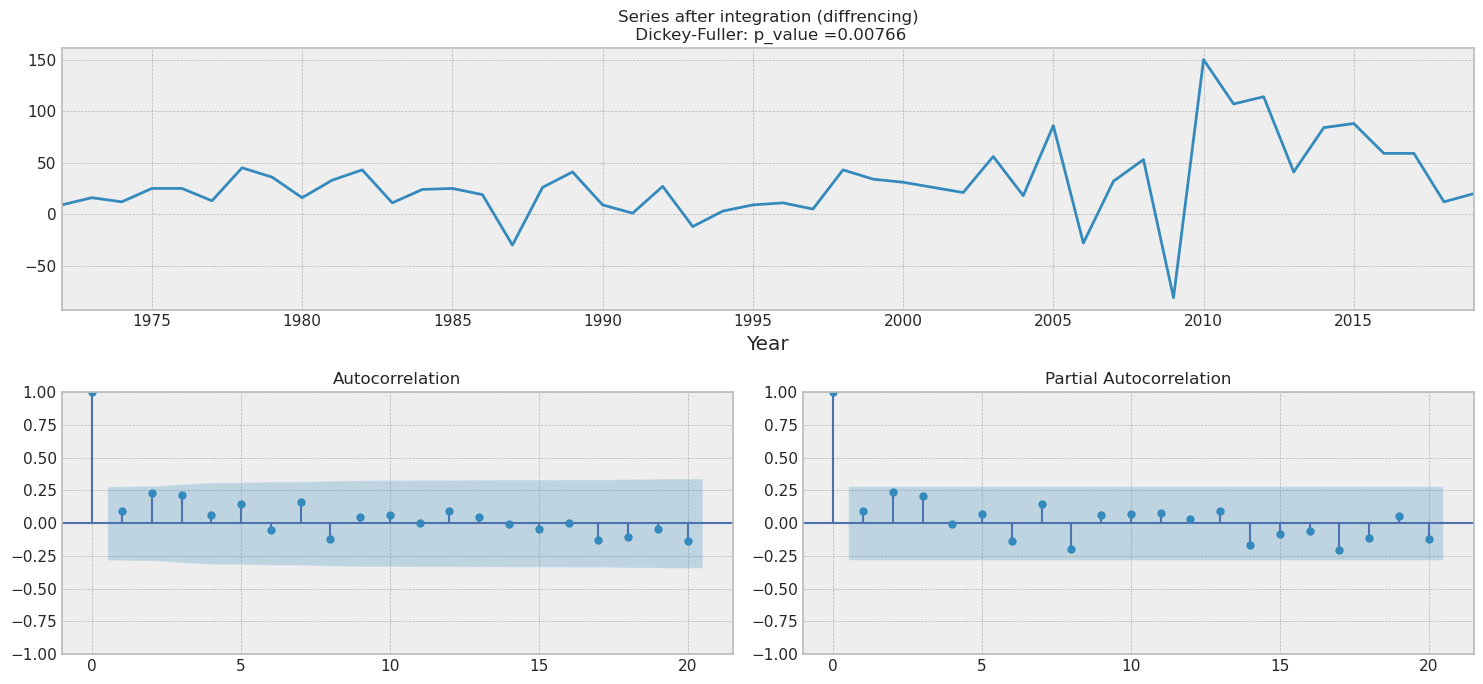

In [9]:
tsplot(dff["consumption"],lags=20, title="Series after integration (diffrencing)")

* A p-value below a significance level (e.g. 0.05) suggests that the time series is stationary, meaning that it does not exhibit any significant trend or seasonality over time.
* No spikes are significant either in the ACF or in the PACF.
* At first glance, an ARIMA(0,1,0) process is best for this dataset

## Choosing the best model

In [10]:
def get_best_model(TS):
    AIC = []
    order = []
    pq_rng = range(3) # [0,1,2,3,4]
    d_rng = range(1,2) # [0,1]
    for d in d_rng:
        for i in pq_rng:
            for j in pq_rng:
                    tmp_mdl = ARIMA(TS, order=(i,d,j)).fit()
                    AIC.append(tmp_mdl.aic)
                    order.append((i,d,j))
    tbl = {"Ordre":order, "AIC":AIC}
    rank = pd.DataFrame(tbl)
    rank.sort_values(by=["AIC"], ascending=True, inplace=True)
    rank.set_index("Ordre", inplace=True)
    return rank

In [11]:
get_best_model(df)

,AIC
Ordre,
"(1, 1, 1)",490.595392
"(2, 1, 1)",491.918027
"(1, 1, 2)",492.003299
"(2, 1, 2)",493.917303
"(2, 1, 0)",494.671914
"(1, 1, 0)",501.763774
"(0, 1, 2)",502.780624
"(0, 1, 1)",506.640011
"(0, 1, 0)",510.714975


* According to the Akaike criterion (AIC), the best model is an ARIMA(1,1,1) with an AIC = 490.59

In [12]:
AR11 = ARIMA(df, order=(1,1,1)).fit()
AR11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            consumption   No. Observations:                   49
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -242.298
Date:                Sat, 15 Apr 2023   AIC                            490.595
Time:                        17:42:32   BIC                            496.209
Sample:                    12-31-1971   HQIC                           492.717
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9849      0.045     21.758      0.000       0.896       1.074
ma.L1         -0.8326      0.124     -6.690      0.000      -1.077      -0.589
sigma2      1382.6265    210.524      6.568      0.000     970.008    1795.245
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):                29.94
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):              10.72   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* All the parameters of the model are significant

# Model Validation

## Checking Residuals

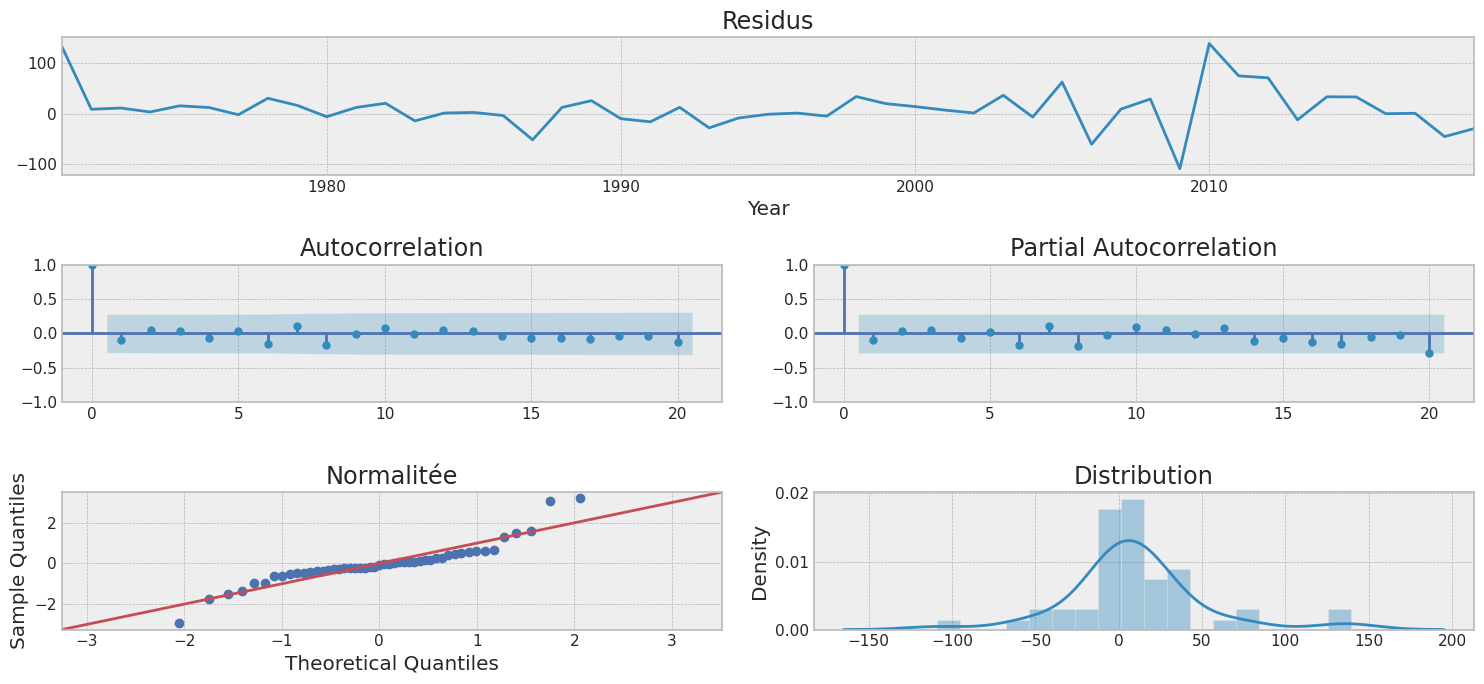

In [13]:
tsplot_resid(AR11.resid,lags=20, title="Residus")

* At first glance, the residuals are the properties of White Noise
* There is no significant peak in ACF nor PACF

## Engle's ARCH Test for Homoscedasticity of Errors
* Ho: The squared residuals are a sequence of white noise - the residuals are homoscedastics.
* H1: Squared residuals could not be fitted with a linear regression model and exhibit heteroscedasticity.

In [14]:
from statsmodels.stats.diagnostic import het_arch
print(f"Critical value : {het_arch(AR11.resid)[2]:.6f}, p_value : {het_arch(AR11.resid)[3]:.6f}")


Critical value : 1.950146, p_value : 0.082398


A p-value of 0.082398 suggests that we cannot reject the null hypothesis at the conventional significance level of 0.05. In other words, there is not enough evidence to conclude that there is conditional heteroskedasticity present in the residuals

## Ljung-Box Test for Autocorrelation of Errors
* H0: Residuals are distributed independently.
* H1: residues are not distributed independently; they show a correlation in series.

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox
LB = acorr_ljungbox(AR11.resid,lags=[10])
print(f"Critical value = {LB.iloc[0,0]:.6f}, p_value ={LB.iloc[0,1]:.6f}")

Critical value = 5.382291, p_value =0.864223


* A p-value greater than 0.05 indicates that there is no significant autocorrelation in the residuals, and thus the null hypothesis cannot be rejected. 
* Therefore, we cannot reject the null hypothesis, and we can assume that there is no significant autocorrelation in the residuals.

# Forecast

## Forecasting 2020-2024

In [16]:
pred = AR11.forecast(5)
years = [2020, 2021, 2022, 2023, 2024]
df_pred = pd.DataFrame({"Years":years, "Forecast":pred})
df_pred.set_index("Years", inplace=True)
df_pred

,Forecast
Years,
2020,1644.334982
2021,1687.999070
2022,1731.002418
2023,1773.355023
2024,1815.066734


## Plotting Results

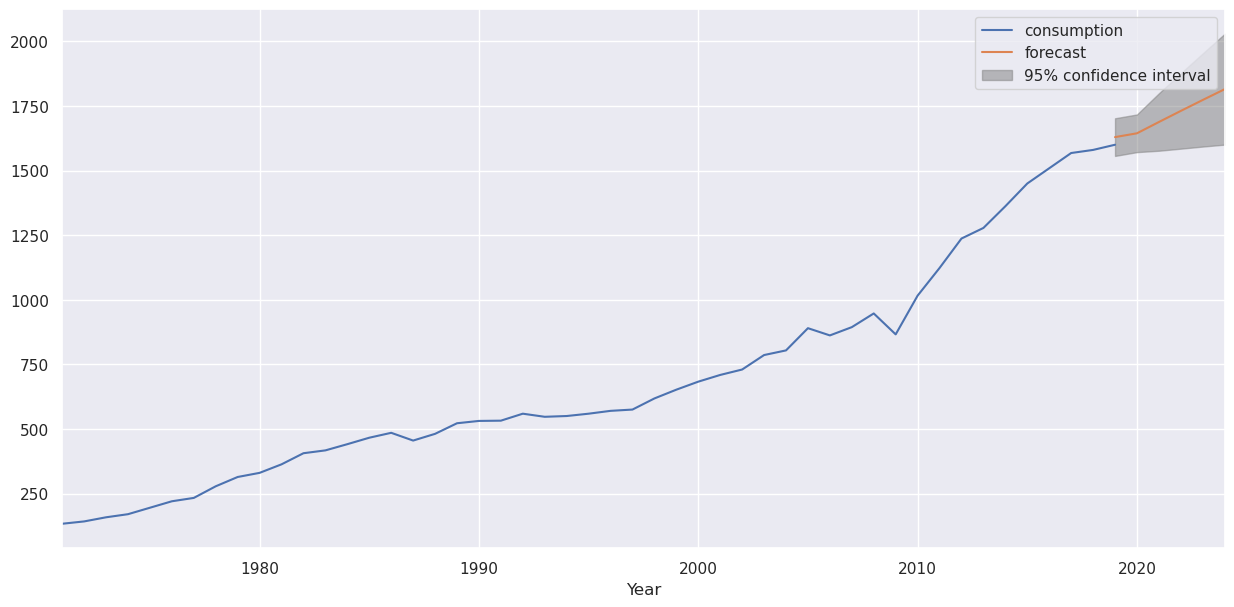

In [17]:
from statsmodels.graphics.tsaplots import plot_predict
fig, ax = plt.subplots(figsize=(15, 7))
ax = df.iloc[:].plot(ax=ax)
fig = plot_predict(AR11,"2019","2024", ax=ax)

# Results
The analysis indicated that the best model for this dataset was an ARIMA(1,1,1) with an AIC of 490.59. The residuals of the model showed white noise properties with no significant autocorrelation. The data did not exhibit significant heteroskedasticity.


# Conclusion
The time series analysis showed that the electricity consumption per person data was best modeled using an ARIMA(1,1,1) model. The residuals of the model showed white noise properties with no significant autocorrelation, and the data did not exhibit significant heteroskedasticity.